In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Importing required libraries**

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plot
from PIL import Image
from random import randint

from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D

from sklearn.metrics import confusion_matrix as CM
import tensorflow.keras.metrics as Metrics

from IPython.display import SVG
import matplotlib.gridspec as gridspec

Using TensorFlow backend.


**Preparing data**

In [4]:
def load_images(directory):
    
    Images = []
    Labels = [] # 0 -> buildings, 1 -> forest, 2 -> glacier, 3 -> mountain, 4 -> sea, 5 -> street
    
    
    for each_label in os.listdir(directory):
        
        # Assigning labels to images in all the 6 categories
        if each_label == 'buildings':
            label = 0
        elif each_label == 'forest':
            label = 1
        elif each_label == 'glacier':
            label = 2
        elif each_label == 'mountain':
            label = 3
        elif each_label == 'sea':
            label = 4
        else:
            label = 5
        
        # Extracting images from each category folder
        for each_image in os.listdir(directory+each_label):
            image = cv2.imread(directory+each_label+r'/'+each_image) # Reading image using open CV library
            image = cv2.resize(image,(150,150)) # Resizing the image, some images might be of different sizes
            
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images,Labels,random_state=817328462) # Shuffles the dataset you just prepared.

In [47]:
train_images, train_labels = load_images('/content/drive/My Drive/Data/seg_train/seg_train/')
val_images, val_labels = load_images('/content/drive/My Drive/Data/seg_test/seg_test/')

In [48]:
# Converting the list of images to numpy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [ ]:
# Checking the shape of training and validation data
print("train has {} records and each record has a shape of {}".format(train_images.shape[0],train_images.shape[1:]))
print("val has {} records and each record has a shape of {}".format(val_images.shape[0],val_images.shape[1:]))

train has 14034 records and each record has a shape of (150, 150, 3)
val has 3010 records and each record has a shape of (150, 150, 3)


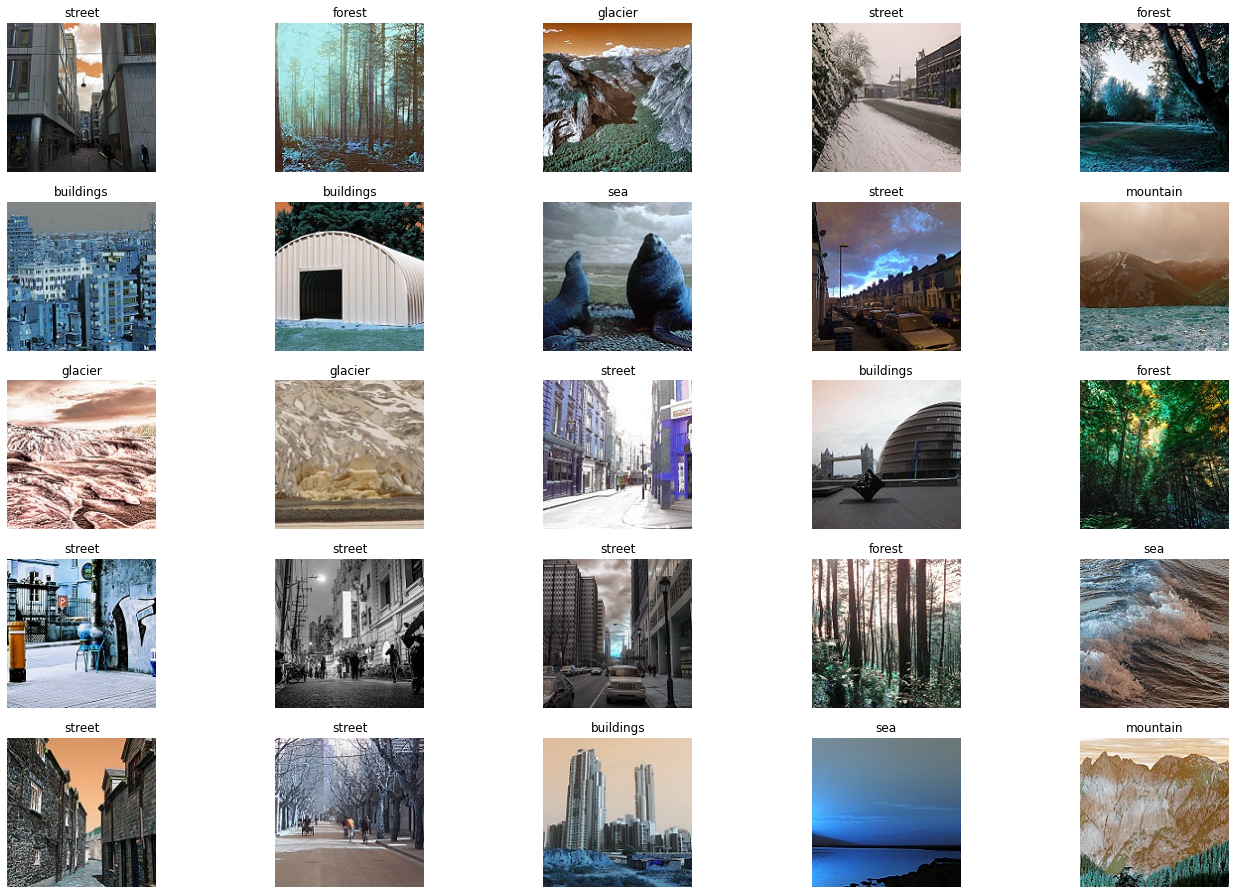

In [ ]:
# Let us look some random images of our dataset

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    return labels[class_code]


f,ax = plot.subplots(5,5)
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title(get_classlabel(train_labels[rnd_number]))
        ax[i,j].axis('off')

In [49]:
size=224
img_rows, img_cols = 150, 150  # input image dimensions
img_channels = 3               # The images are coloured - RGB.

nb_classes = 6
batch_size = 64

In [50]:
# Resizing all the images

def resize(p, size):
    return Image.fromarray(p).resize(size=(size,size))

def resize_all(arr, size):
    t = []
    for i in range(arr.shape[0]):
      t.append(np.array(resize(arr[i], size)))
    return(np.array(t))

train_images = resize_all(train_images, size)
val_images = resize_all(val_images, size)

In [51]:
# Scaling images to have the pixels range between 0 and 1 (for better backpropagation)
train_images = train_images.astype('float32')/255.
val_images = val_images.astype('float32')/255.

# Dummifying targets
train_labels = to_categorical(train_labels, nb_classes)
val_labels = to_categorical(val_labels, nb_classes)

**CNN Model - As part of transfer learning using pre-trained VGG model for feature extraction and tuning it for classification.**

In [52]:
def vgg_tl(nb_classes, freez_wts=True, learn_rate=0.001):
    trained_model = VGG16(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    pred_vgg= Dense(nb_classes,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_vgg)
    
    for layer in trained_model.layers:
        layer.trainable=(1-freez_wts)
    
    adam = Adam(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    
    return(model)

In [ ]:
vgg_model = vgg_tl(nb_classes=nb_classes, freez_wts=True)
vgg_model.fit(train_images, train_labels,
          validation_data=(val_images,val_labels),
          batch_size=batch_size,
          epochs=10)

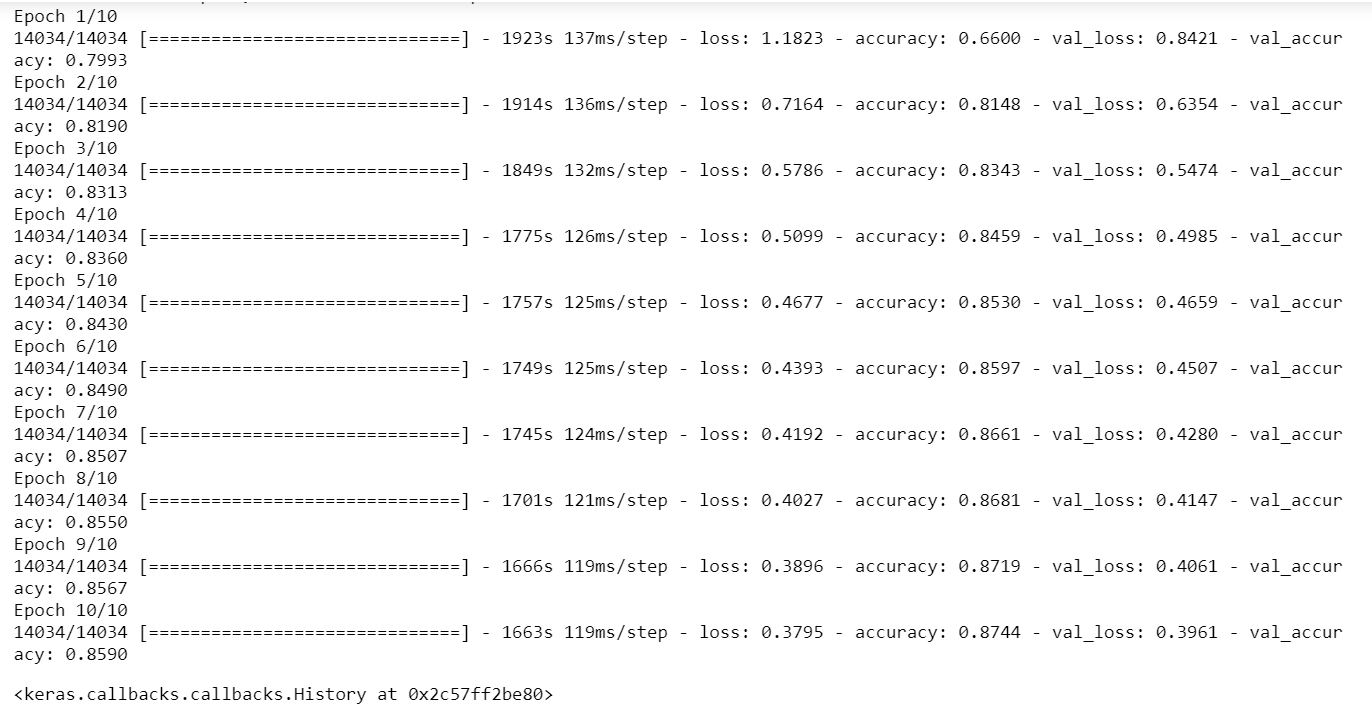

In [7]:
import pickle as pkl

# Taking backup of the model
def create_backupfiles(filename,dfin):
  outfile=open(filename,'wb')
  pkl.dump(dfin,outfile)
  outfile.close()

In [8]:
os.chdir('/content/drive/My Drive/Data/')
create_backupfiles('vgg_model',vgg_model)

In [9]:
# Reload backedup model
def reload_backupfiles(filename):
  infile=open(filename,'rb')
  dfout=pkl.load(infile)
  infile.close()
  return(dfout)

In [10]:
os.chdir('/content/drive/My Drive/Data/')
vgg_model=reload_backupfiles('vgg_model')

In [11]:
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

**Evaluate the model performance on validation data**

In [53]:
vgg_model.evaluate(val_images, val_labels, verbose=1)

3010/3010 [==============================] - 8s 3ms/step


[0.39879665747037363, 0.8578073382377625]

**Preparing test data**

In [13]:
!pwd

/content/drive/My Drive/Data


In [14]:
test_images, test_labels = load_images('seg_pred/')
test_images = np.array(test_images)

In [15]:
#The test labels make no sense here. Ignoring test_labels
del test_labels
import gc
gc.collect()

256

In [16]:
print("We have {} images which are to be classified in test data and each image is of size {}".format(test_images.shape[0],test_images.shape[1:]))

We have 7321 images which are to be classified in test data and each image is of size (150, 150, 3)


In [19]:
# Resizing images to 224 X 224 X 3
test_images = resize_all(test_images, size)

# Scaling images to have the pixels range between 0 and 1 (for better backpropagation)
test_images = test_images.astype('float32')/255.

In [20]:
print("After sclaing we have {} images which are to be classified in test data and each image is of size {}".format(test_images.shape[0],test_images.shape[1:]))

After sclaing we have 7321 images which are to be classified in test data and each image is of size (224, 224, 3)


**Making predictions**

In [24]:
pred_probs = vgg_model.predict(test_images)
print(pred_probs)

[[0.00457568 0.18737441 0.16900255 0.6016018  0.022799   0.01464656]
 [0.00594297 0.00560503 0.14885484 0.7682379  0.06173285 0.00962641]
 [0.03393679 0.00149321 0.502333   0.21543965 0.02818414 0.21861327]
 ...
 [0.00225436 0.937417   0.03406055 0.02110555 0.00419042 0.00097213]
 [0.00145229 0.00314008 0.1467623  0.07473945 0.76965994 0.00424592]
 [0.00165111 0.00383266 0.02997717 0.08393783 0.87847215 0.00212912]]


In [34]:
pred_classes = np.argmax(pred_probs,axis=1)
print(pred_classes)
len(pred_classes)

[3 3 2 ... 1 4 4]


7321

Below plot shows the predicted class label on top of the image and probabilities below of the image for few random images.

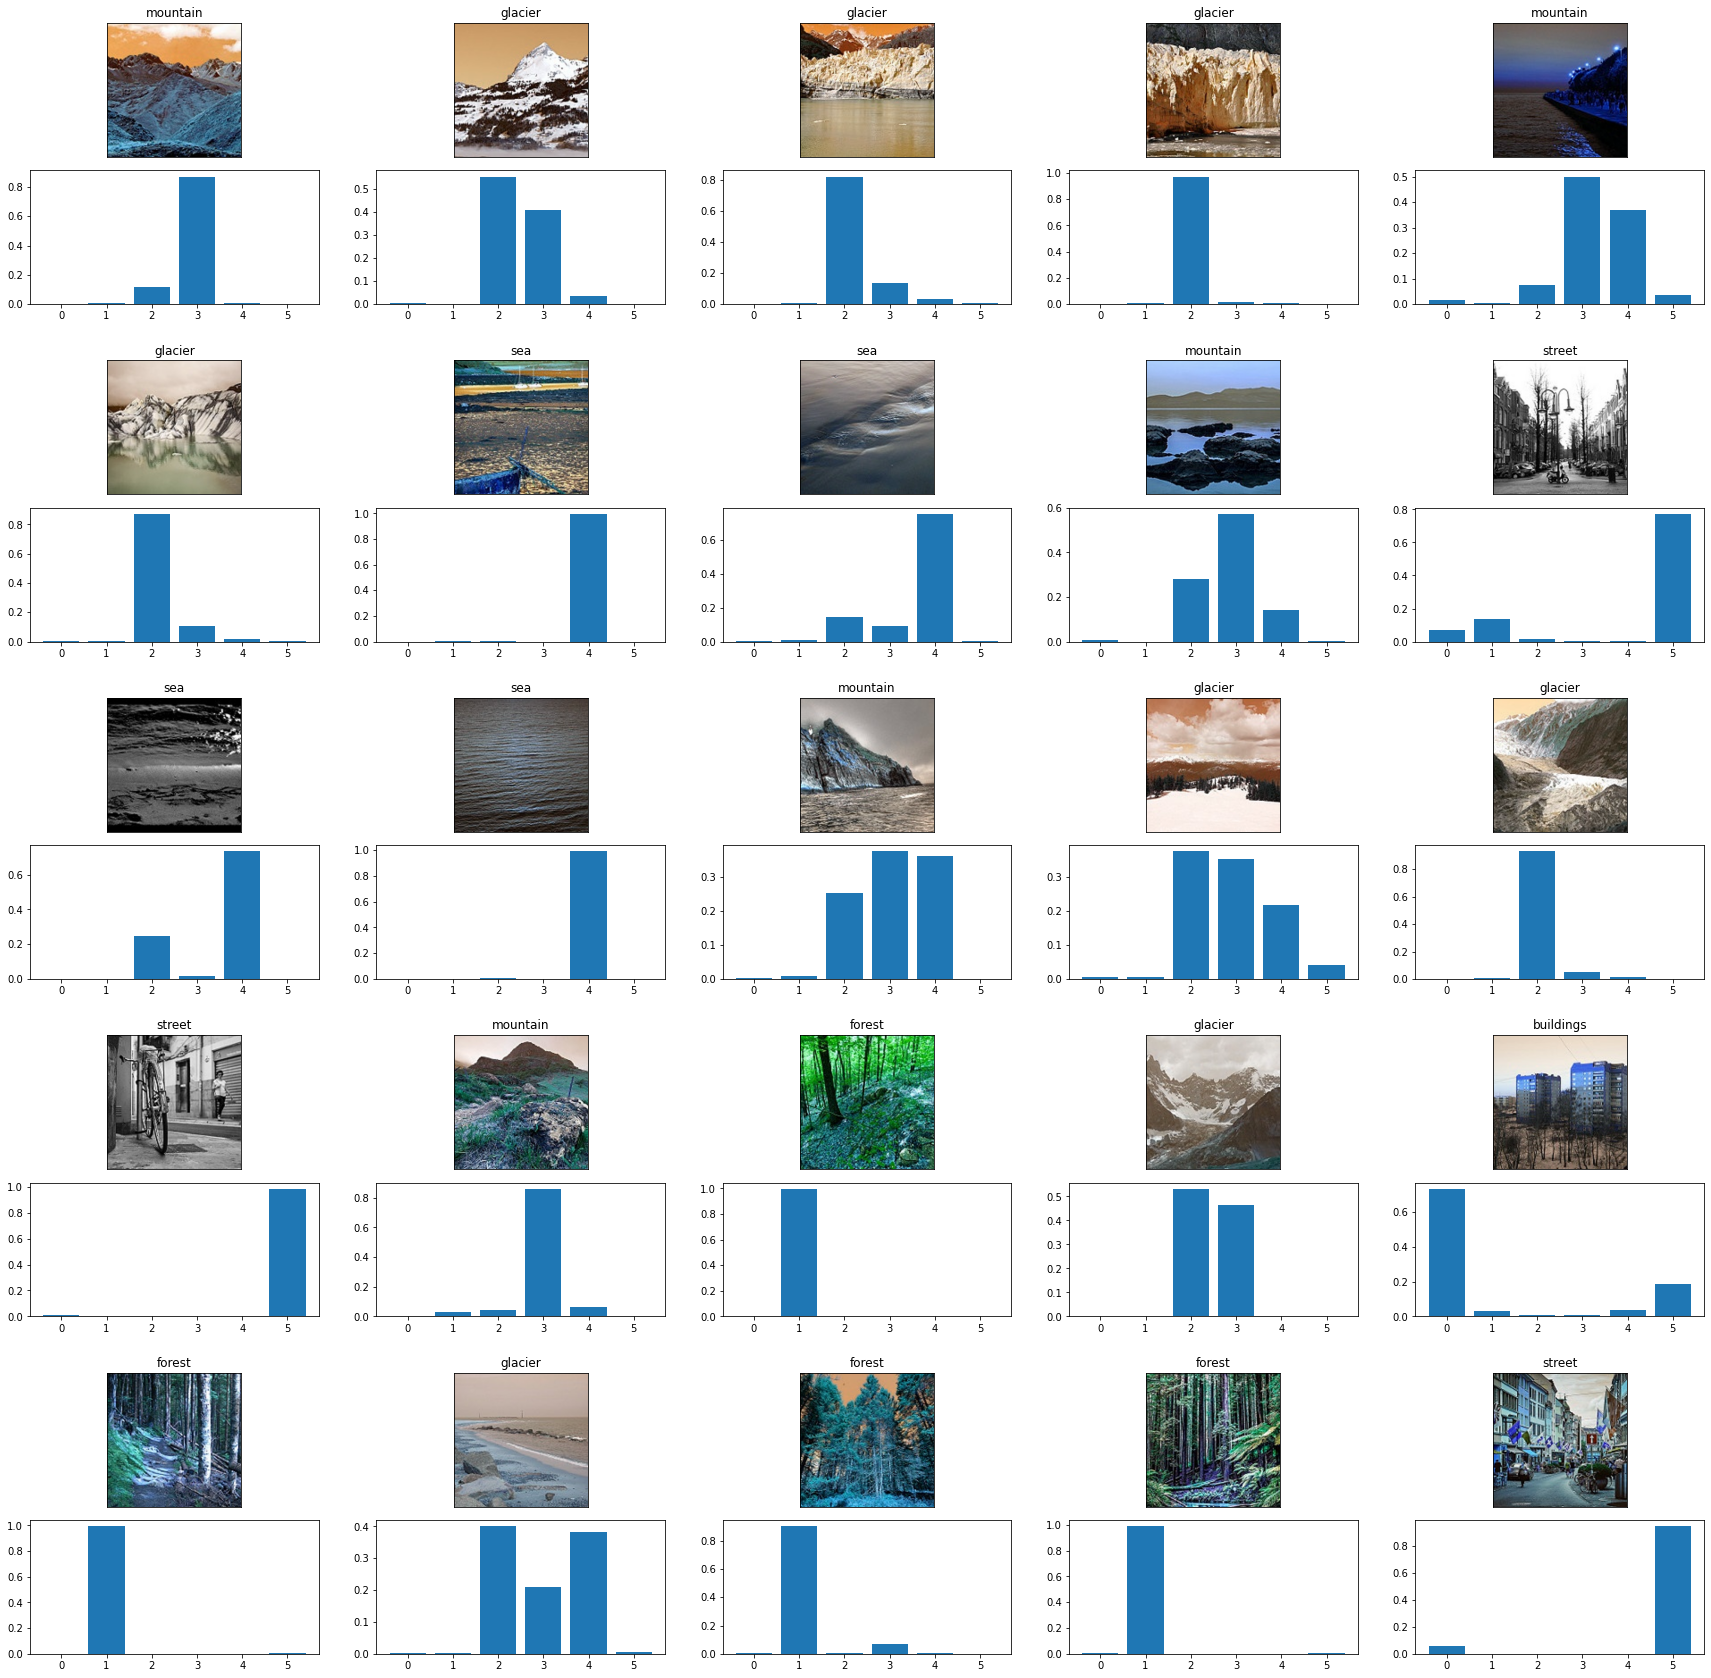

In [44]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,pred_classes.shape[0])
    pred_image = np.array([test_images[rnd_number]])
    label_id = np.asscalar(np.argmax(vgg_model.predict(pred_image),axis=1))
    pred_class = get_classlabel(label_id)
    pred_prob = vgg_model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plot.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)

In [27]:
pred_classes=pd.DataFrame(pred_classes)
pred_classes=pred_classes.reset_index()
pred_classes.columns=['image_id','label']
pred_classes.head()

,image_id,label
0,0,3
1,1,3
2,2,2
3,3,4
4,4,1


In [28]:
pred_classes.label.value_counts()

2    1333
3    1264
4    1207
5    1194
1    1183
0    1140
Name: label, dtype: int64

In [31]:
pred_classes.to_csv('test_predictions.csv',index=False)